In [1]:
#!pip install install dowhy
#!pip install RISE
#!pip install pgmpy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.inference import VariableElimination
import graphviz 
import pandas

from dowhy import CausalModel
import dowhy.datasets
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


# Goal

When we explain a complex concept in white board, we draw some circles and arrows joining them. That in effect is a DAG (direct acyclic graph) - assuming there are no closed cycles. That is quintessence way to express domain knowledge.
We can take a DAG and:
1. store it as a __Knowledge Graph__ in a Graph DB with some kind of data
2. convert it to a __Bayesian Network__ by adding the Conditional Probability Distribution (CPD) to it
3. convert it to a __Causal model__ (Bayesian Network with a little more rigor if needed) with some structural equation

Each of the above takes domain knowledge and helps answer some questions about it.

__In this notebook, we will take a DAG, and drive it through the evolution of KG -> Bayesian Network -> Causal Model to make clear the options we have in mining domain knowledge.__


## Knowledge Graph
follows

## Bayesian Network

_These examples are all taken from the excellent course https://www.coursera.org/specializations/probabilistic-graphical-models . To be more precise, these were from an earlier version of the course - for which there is no link anymore - way back in 2012/13s. The course may have looked slightly different then. But these excellent examples are owed to Prof Koller._

#### This example shows how we define:
- a DAG
- and the Conditional Probability Distribution (CPD)
- and for sake of easy visualization show the DAG as a graphviz.Digraph()
#### Note:
- Then we instrospect the model

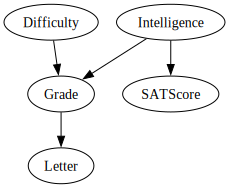

In [28]:
# A Bayesian Net visual represntation
studentnetwork=graphviz.Digraph()
studentnetwork.edge('Difficulty', 'Grade')
studentnetwork.edge('Intelligence', 'Grade')
studentnetwork.edge('Intelligence','SATScore')
studentnetwork.edge('Grade', 'Letter')
studentnetwork

### Explain the DAG
- difficulty implies how hard is the course that the student takes
- intelligence implies student's intelligence
- grade is the grade in the course work
- letter is the strenght of the recommendation letter given to the student by the Prof
- SAT score obtained by the student.

For simplicity, all variables are binary valued except for Grade which has 3 values.

This is a simple student network. This is the not the only model that may exist. There could be many other models. For example, there could be an arrow from Intelligence to Difficulty because more intelligent students take more harder courses etc. But let us assume that experts have got together and said that for the problem we are trying to solve, this is good enough approximation.

We will next define a Bayesian Network with this. So for now, we will assume we know the CPD. Later on, we will have another example of Bayesian Network where we will give the raw data - and the network will be `fitted` to that data to generate the CPD.

In [4]:
# Create a networkx graph object to show the Bayesian Net structure
bbn = nx.DiGraph([('Difficulty', 'Grade'),
                           ('Intelligence', 'Grade'),
                           ('Intelligence','SATScore'),
                           ('Grade', 'Letter')])

# We could easily defined this directly in BayesianNetwork([('Difficulty', 'Grade'),
#                           ('Intelligence', 'Grade'),
#                           ('Intelligence','SATScore'),
#                           ('Grade', 'Letter')])
# can give the networkx digraph as input directly
student_model = BayesianNetwork(ebunch=bbn)
cpd_table = TabularCPD('grade', 2,
                       [[0.7, 0.6, 0.6, 0.2],[0.3, 0.4, 0.4, 0.8]],
                       ['intel', 'diff'], [2, 2])

cpd_difficulty = TabularCPD(
    variable="Difficulty", variable_card=2, values=[[0.6], [0.4]]
)
cpd_intelligence = TabularCPD(
    variable="Intelligence", variable_card=2, values=[[0.7], [0.3]]
)
cpd_grade = TabularCPD(
    variable="Grade",
    variable_card=3,
    values=[[0.3, 0.05, 0.9,0.5], [0.4, 0.25, 0.08, 0.3],[0.3, 0.7, 0.02, 0.2]],
    evidence=["Intelligence","Difficulty"],
    evidence_card=[2, 2],
)

cpd_satscore = TabularCPD(
    variable="SATScore",
    variable_card=2,
    values=[[0.95, 0.2], [0.05, 0.8]],
    evidence=["Intelligence"],
    evidence_card=[2],
)

cpd_letter = TabularCPD(
    variable="Letter",
    variable_card=2,
    values=[[0.1, 0.4, 0.99], [0.9, 0.6, 0.01]],
    evidence=["Grade"],
    evidence_card=[3],
)

# Associating the parameters with the model structure
student_model.add_cpds(
    cpd_difficulty, cpd_intelligence, cpd_grade, cpd_satscore, cpd_letter
)

In [5]:
for cpdList in student_model.get_cpds():
        print(cpdList.variable)
        print(cpdList.variables)
        print(cpdList)
        print('\n\n')

Difficulty
['Difficulty']
+---------------+-----+
| Difficulty(0) | 0.6 |
+---------------+-----+
| Difficulty(1) | 0.4 |
+---------------+-----+



Intelligence
['Intelligence']
+-----------------+-----+
| Intelligence(0) | 0.7 |
+-----------------+-----+
| Intelligence(1) | 0.3 |
+-----------------+-----+



Grade
['Grade', 'Intelligence', 'Difficulty']
+--------------+-----------------+-----+-----------------+
| Intelligence | Intelligence(0) | ... | Intelligence(1) |
+--------------+-----------------+-----+-----------------+
| Difficulty   | Difficulty(0)   | ... | Difficulty(1)   |
+--------------+-----------------+-----+-----------------+
| Grade(0)     | 0.3             | ... | 0.5             |
+--------------+-----------------+-----+-----------------+
| Grade(1)     | 0.4             | ... | 0.3             |
+--------------+-----------------+-----+-----------------+
| Grade(2)     | 0.3             | ... | 0.2             |
+--------------+-----------------+-----+------------

### Instrospect the model
- Checking if the cpds are valid for the model
- Viewing nodes of the model
- Viewing edges of the model
- Checking independcies of a node
- Listing all Independencies


In [6]:
# Checking if the cpds are valid for the model
student_model.check_model()

True

In [7]:
# Viewing edges of the model
student_model.edges()

OutEdgeView([('Difficulty', 'Grade'), ('Grade', 'Letter'), ('Intelligence', 'Grade'), ('Intelligence', 'SATScore')])

In [8]:
# Checking independcies of a node
student_model.local_independencies("Grade")

(Grade ⟂ SATScore | Difficulty, Intelligence)

In [9]:
# Listing all Independencies
student_model.get_independencies()

(Grade ⟂ SATScore | Intelligence)
(Grade ⟂ SATScore | Difficulty, Intelligence)
(Grade ⟂ SATScore | Intelligence, Letter)
(Grade ⟂ SATScore | Difficulty, Intelligence, Letter)
(SATScore ⟂ Difficulty)
(SATScore ⟂ Difficulty, Grade, Letter | Intelligence)
(SATScore ⟂ Letter | Grade)
(SATScore ⟂ Grade, Letter | Difficulty, Intelligence)
(SATScore ⟂ Letter | Difficulty, Grade)
(SATScore ⟂ Difficulty, Letter | Intelligence, Grade)
(SATScore ⟂ Difficulty, Grade | Intelligence, Letter)
(SATScore ⟂ Letter | Difficulty, Intelligence, Grade)
(SATScore ⟂ Grade | Difficulty, Intelligence, Letter)
(SATScore ⟂ Difficulty | Intelligence, Grade, Letter)
(Difficulty ⟂ Intelligence, SATScore)
(Difficulty ⟂ SATScore | Intelligence)
(Difficulty ⟂ Letter | Grade)
(Difficulty ⟂ Intelligence | SATScore)
(Difficulty ⟂ Letter, SATScore | Intelligence, Grade)
(Difficulty ⟂ SATScore | Intelligence, Letter)
(Difficulty ⟂ Letter | Grade, SATScore)
(Difficulty ⟂ SATScore | Intelligence, Grade, Letter)
(Difficulty ⟂

#### What is the probability of 'Difficulty': 0, 'Intelligence':1 , 'Grade':2,'SATScore':1, 'Letter': 1

In [10]:
student_model.get_state_probability({'Difficulty': 0, 'Intelligence':1 , 'Grade':2,'SATScore':1, 'Letter': 1})

#### Cross check the answer manually from the CPDs

In [11]:
0.6 * 0.3 * 0.02 * 0.01 * 0.8

In [12]:
student_model.get_state_probability({'Difficulty': 0})

In [13]:
student_model.get_state_probability({'Intelligence':1 })

### Different kinds of Reasoning with the model

#### Calculate the Marginal Probability - of Letter:1

In [14]:
student_model.get_state_probability({'Letter':1})

### Different types of reasoning

1. Causal Reasoning
- These flow down from cause to effect.
- P(Letter|Intelligence=0)
- P(Letter|Intelligence=0, Difficulty=0)

1. Evidential Reasoning
- These flow up from effect to what it can tell about the causes
- P(Difficulty|Grade=2)
- P(Intelligence|Grade=2)


1. Inter Causal Reasoning
- There is no arrow between Difficulty and Intelligence, the 2 causes for Grade. However, observing Grade and Difficulty will we know anything more about the `other cause` ie. Intelligence
- P(Intelligence|Grade=2, Difficulty=1)

All of the above gives an intiution of how knowing one variable informs about the probability of another. Note that there is no clash here with the CPD tables defined. This `knowing one variable informs about the probability of another` is called flow of information of active trail. Let us see how __`Active Trail`__ works. This is an important concept used heavily in Causal Models!


#### Calculate the Conditional Probability - of P(Letter|Intelligence=0)

In [15]:
#from pgmpy.inference import VariableElimination

# it is NOT
#student_model.get_state_probability({'Letter':1,'Intelligence':0})

print('P(Letter|Intelligence=0)')
infer = VariableElimination(student_model)
posterior_p = infer.query(['Letter'], evidence={'Intelligence': 0})
#posterior_p = infer.query(['Letter'])
print(posterior_p)

P(Letter|Intelligence=0)
+-----------+---------------+
| Letter    |   phi(Letter) |
+===========+===============+
| Letter(0) |        0.6114 |
+-----------+---------------+
| Letter(1) |        0.3886 |
+-----------+---------------+


#### Calculate the Conditional Probability - of P(Letter|Intelligence=0, Difficulty=0)

In [16]:
print('P(Letter|Intelligence=0, Difficulty:0)')
infer = VariableElimination(student_model)
posterior_p = infer.query(['Letter'], evidence={'Intelligence': 0, 'Difficulty':0})
print(posterior_p)


P(Letter|Intelligence=0, Difficulty:0)
+-----------+---------------+
| Letter    |   phi(Letter) |
+===========+===============+
| Letter(0) |        0.4870 |
+-----------+---------------+
| Letter(1) |        0.5130 |
+-----------+---------------+


#### Calculate the Conditional Probability - of P(Difficulty|Grade=2)

In [17]:
print('P(Difficulty|Grade=2)')
infer = VariableElimination(student_model)
posterior_p = infer.query(['Difficulty'], evidence={'Grade': 2})
print(posterior_p)


P(Difficulty|Grade=2)
+---------------+-------------------+
| Difficulty    |   phi(Difficulty) |
+===============+===================+
| Difficulty(0) |            0.3707 |
+---------------+-------------------+
| Difficulty(1) |            0.6293 |
+---------------+-------------------+


#### Calculate the Conditional Probability - of P(Intelligence|Grade=2)

In [18]:
print('P(Intelligence|Grade=2)')
infer = VariableElimination(student_model)
posterior_p = infer.query(['Intelligence'], evidence={'Grade': 2})
print(posterior_p)


P(Intelligence|Grade=2)
+-----------------+---------------------+
| Intelligence    |   phi(Intelligence) |
+=================+=====================+
| Intelligence(0) |              0.9211 |
+-----------------+---------------------+
| Intelligence(1) |              0.0789 |
+-----------------+---------------------+


#### P(Intelligence|Grade=2, Difficulty=1)

In [19]:
print('P(Intelligence|Grade=2,Difficulty=1)')
infer = VariableElimination(student_model)
posterior_p = infer.query(['Intelligence'], evidence={'Grade': 2, 'Difficulty': 1})
print(posterior_p)

P(Intelligence|Grade=2,Difficulty=1)
+-----------------+---------------------+
| Intelligence    |   phi(Intelligence) |
+=================+=====================+
| Intelligence(0) |              0.8909 |
+-----------------+---------------------+
| Intelligence(1) |              0.1091 |
+-----------------+---------------------+


#### A little more complex Intercausal Reasoning
P(Intelligence|Grade=2, Difficulty=1)


### Active Trail

When information flows, it is an active trail. When information flow is blocked, there must be a V-Structure (with out evidence) or Inverse V-structure with evidence. Let us see the details.
1. An example - Once we know the SAT scores, we can know infer about the intelligence of the students and the grade. `But if the grade is not known`, then we are stuck at the V-structure. However, if grade is observed, then we can also infer about the course difficulty.
2. Another example - knowing grade of the student may help us may allow us to infer about the intelligence and the difficulty of the course. This is an example of V-Structure becoming an active trail because the Z variable is observable now.
3. Another example - knowing the grade and difficulty of the course, we can infer about the intelligence of the student. Again, this is possible because V-Structure becomes active because Z variable is observable now. This particular inter causal phenomenon is also called explaining away. Once we know the grade and course difficulty, it is easy to infer about the students intelligence - kind of obvious.

#### Formal definition of Active Trail
So formally what is active trail.


#### Fork or Common cause

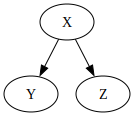

In [20]:
 
fork=graphviz.Digraph()
fork.edge('X','Y')
fork.edge('X','Z')
fork

#### V-Structure or Common Effect

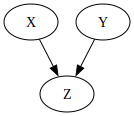

In [21]:
vstructure=graphviz.Digraph()
vstructure.edge('X','Z')
vstructure.edge('Y','Z')
vstructure

#### Confounder or Common Cause for 2 variables which also may be causally linked

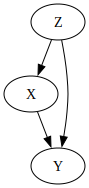

In [22]:
confounder=graphviz.Digraph()
confounder.edge('Z','X')
confounder.edge('Z','Y')
confounder.edge('X','Y')
confounder

#### This example shows how we define:
- a DAG
- and the raw data
- and for sake of easy visualization show the DAG as a graphviz.Digraph()
#### Note:
- The parameters for the the Conditional Probability Distribution (CPD) are calculated automatically.
- In the example above, we did input the DAG and CPD

In [23]:
model = BayesianNetwork([('A', 'B'), ('B', 'C'),
                       ('A', 'D'), ('D', 'C')])
values = pandas.DataFrame(np.random.randint(low=0, high=2, size=(1000, 4)),
                      columns=['A', 'B', 'C', 'D'])
model.fit(values)
for cpdList in model.get_cpds():
        print(cpdList)
#cpdB = model.get_cpds('B')
#print(cpdB)

+------+-------+
| A(0) | 0.507 |
+------+-------+
| A(1) | 0.493 |
+------+-------+
+------+--------------------+--------------------+
| A    | A(0)               | A(1)               |
+------+--------------------+--------------------+
| B(0) | 0.5029585798816568 | 0.5273833671399595 |
+------+--------------------+--------------------+
| B(1) | 0.4970414201183432 | 0.4726166328600406 |
+------+--------------------+--------------------+
+------+--------------------+-----+---------------------+
| B    | B(0)               | ... | B(1)                |
+------+--------------------+-----+---------------------+
| D    | D(0)               | ... | D(1)                |
+------+--------------------+-----+---------------------+
| C(0) | 0.5120967741935484 | ... | 0.5196850393700787  |
+------+--------------------+-----+---------------------+
| C(1) | 0.4879032258064516 | ... | 0.48031496062992124 |
+------+--------------------+-----+---------------------+
+------+---------------------+------

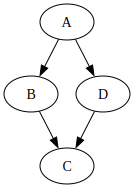

In [24]:
# Next Model - The Bayesian Net structure
random=graphviz.Digraph()
random.edge('A','B')
random.edge('B','C')
random.edge('A','D')
random.edge('D','C')
random

### IGNORE Below this - not complete

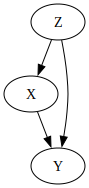

In [25]:
effectmodifier=graphviz.Digraph()
effectmodifier.edge('Z','X')
effectmodifier.edge('Z','Y')
effectmodifier.edge('X','Y')
effectmodifier

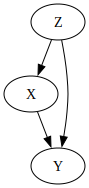

In [26]:
moderator=graphviz.Digraph()
moderator.edge('Z','X')
moderator.edge('Z','Y')
moderator.edge('X','Y')
moderator

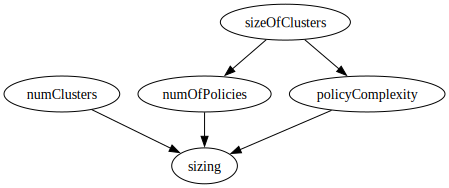

In [27]:
acm=graphviz.Digraph()
acm.edge('numClusters','sizing')
acm.edge('sizeOfClusters','numOfPolicies')
acm.edge('numOfPolicies','sizing')
acm.edge('policyComplexity','sizing')
acm.edge('sizeOfClusters','policyComplexity')
acm

## Causal Model